https://mp.weixin.qq.com/s/guh05AZoKoc1xgApNRl99Q

# 概述

在做特征工程遇到类别变量时，需要把其编码为数值变量。

常见的有如下的场景：

* ONE one-hot-encoder
* LE Label-encoder
把类别编码为整数值
    * OrdinalEncoder顺序编码  
        按照指定的顺序编码为整数值。如一级二级三级等

* Mean encodings均值编码
均值编码是一种非常强大的技术，它有很多名字，例如:likelihood encoding、target encoding，但这里我们叫它均值编码。

## 难点：超多类别(如超过100类)的分类特征的处理
在日常工作中，遇到的大部分字段都是分类字段。对于有几十w上百w样本的数据，常常会遇到一些特征分类树超过几k的情况。

这种特征肯定是包含很多有用的信息，如果直接删掉，非常可惜！但是如果直接进行ONE编码，则会造成特征数大量增加，从而导致计算量暴增。而且也不合理。

几种想到的解决方法：
### 对ONE后的数据降维
待分析
### 把出现频次少于n次的分类合成1类
不合理，因为小类之间label的数量并不相同，如f1==a有80%的label=1，f1==b只有10%的label=1
### 对于二分类而言，可以把所有出现过label=1的分类设置为1，其余分类设置为0
这个方案的优点是考虑了label的影响。缺点也显而易见：对于所有出现过label=1的分类也是有很大不同的，如f1==a有80%的label=1，f1==b只有10%的label=1。  
而且，对于多分类而言，这个想法无法使用。

### 较合理的方法：target encoding
target encode考虑了target_label的prior(先验概率：所有样本的均值)和后验概率(在分类1中的均值)，假设类别1经过target encode编码后的值为0.9，类别2经过target encode编码后的值为0.1，则表示属于类别1的样本 比 属于类别2的样本 被分类为target_label=1的概率更大。 

CatBoost处理类别变量的方式和target encoding的思想很像！

## XGBoost之类别特征的处理

https://www.biaodianfu.com/categorical-features.html

无论是XGBoost还是其他的Boosting Tree，使用的Tree都是cart回归树，这也就意味着该类提升树算法只接受数值特征输入，不直接支持类别特征，默认情况下，xgboost会把类别型的特征当成数值型。事实上，对于类别特征的处理，参考XGBoost PPT如下：
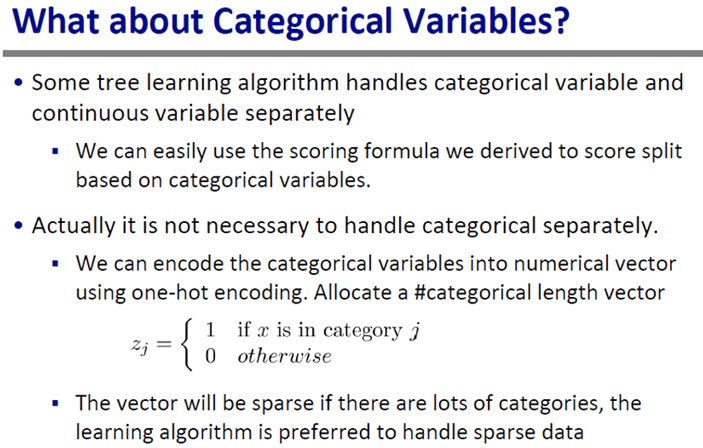

在另一个issues上也提到过（tqchen commented on 8 May 2015）：

    One-hot encoding could be helpful when the number of categories are small( in level of 10 to 100). In such case one-hot encoding can discover interesting interactions like (gender=male) AND (job = teacher).

    While ordering them makes it harder to be discovered(need two split on job). However, indeed there is not a unified way handling categorical features in trees, and usually what tree was really good at was ordered continuous features anyway..

## 最佳解决方案！！！
处理分类变量很重要的意义在于：

目前只有catboost等少数模型封装了处理分类变量的方法；这就意味着如果分类变量处理不好，很多优秀的模型，如神经网络、xgboost等都无法使用！


如何做？目前的资源：
* kaggle的target_encode方法；

* 看看catboost编码完的特征能否分离出来；

* skleran的encoder相关类

* 第三方包category_encoders


### ONE和TE的区别：

假设一批样本，做4分类问题,label=[0, 1, 2, 3]。 

其中一个分类特征：feature有3个分类甲乙丙

经过ONE编码为
```
1 0 0
0 1 0
0 0 1
```
ONE编码的一个很大的问题是根本不考虑业务，无论是几分类问题，是否有监督等，编码都一样，这实际上使得在有监督问题中label的效力在特征编码时并没有得到利用。

TE编码怎么编？

在甲中，分属类别 0, 1, 2, 3的个数为 10, 20, 15, 5

那么分类甲的编码为0.2, 0.4, 0.3, 0.1

显然他们加起来是等于1的，所有可以省略掉一个，一般会省略分类为0的列，那么编码后的结果为

分裂为3类features1_1,features1_2,features1_3

    甲编码为( 0.4, 0.3, 0.1)
    乙
    丙

very interesting！！！

可以看到，这和ONE编码正好反过来！

ONE编码是按照feature的分类来编码的，如feature中有甲乙丙3类，则会裂变为feature_甲(1,0,0), feature_乙, feature_丙3列，可以用(000)表示缺失值，每一列都只有0|1两个分类。

TE编码是按照label的分类来编码的, 如label有0123四类, 那么feature裂变为feature0...feature4

甲编码为(0.1， 0.2， 0.3， 0.4)表示feature=甲的样本数totalcount

    其中label==0的样本数量为c0，则c0/totalcount=0.1
    其中label==1的样本数量为c1，则c1/totalcount=0.2
    其中label==2的样本数量为c2，则c2/totalcount=0.3
    其中label==3的样本数量为c3，则c3/totalcount=0.4

按照catboost给的公式，可能出现totalcount=0的情况：

公式修改为：

$$feature_i=\frac{(ci + prior)}{(totalcount+1)}$$

其中prior是一个常数，那么它的意义就不大，只是避免了被编码为0！


因为feature=甲的样本都是有label的，所以它们相加=1，可以去掉1列

### TE编码的优点
这种编码方法天然可以对缺失值进行编码！！！假设缺失值编码为(0.1， 0.2， 0.3， 0.4)，则有同样的意义！！！

这种方法还规避了特征分类爆炸的问题(如：常常会遇到某些特征分类数成百上千的情况，这就造成如果使用ONE时特征数量会爆炸)，因为label的分类数通常很少！

同时，相较于ONE而言，TE的编码也有更多的业务含义，假设feature的分类甲编码为100，表示甲的样本都属于一个label，那么自然对于这个label而言，甲这个特征是很显著的！

而且，对于feature的编码并不会影响对于label的编码，即使feature使用了TE，如果模型选择神经网络，那么label照样可以使用ONE，并不冲突！！！

### TE是否可以涵盖OrdinalEncoding
现在看来，使用TE时最有效和彻底的利用了人的经验，所以所有的类别特征都应该使用TE，不用再考虑其它的编码方式！

### 对于不平衡的特征类别是否有问题？
假设二分类问题，feature有1000个分类，其中分类0有9000个样本（其中有一半为阳性），其它的分类都只有1个样本，其中类别1-500的label=1，类别501-999的label=0，采用TE编码后的结果为：

cls|feature_0| feature_1
-|-|-
分类0|0.5|0.5
分类1-500|0|1
分类501-999|1|0

可以看到，TE编码还起到了特征分类压缩的作用，原本有1000个分类，现在被压缩为了3个分类！！！

我管你是什么分类，只要label的分布是一样的，我就认为是一个分类，这个貌似也说的过去！

这个可能还可以细分一下，如有分类1中有1000个样本，都为阳性，分类2中只有一个样本，这个样本为阳性，使用TE的编码是一样的，但是明显分类1应该对于阳性更加显著一些，即，如果一个样本的feature=1时，我们基本预测这个样本是阳性；而如果一个样本的feature=2时，我们虽然预测这个样本是阳性，但是把握显然不然前面的大！！！所以，TE的公式应该把total_count_i考虑进去！应该犹如sigmoid形式，当total_count_i=0时，为0.5，然后随着当total_count_i增大，值迅速增大，然后慢慢趋向饱和值1。

$$feature_i=\frac{(ci + prior)}{(totalcount+1)}*\frac{1}{1+exp(-totalcount)}$$

# ONE

In [1]:
import pandas as pd
import sys
sys.path.append('/Users/luoyonggui/PycharmProjects/mayiutils_n1/mayiutils/data_prepare')


In [2]:
from cat_feature_encoder import CatFeatureEncoder as cfe

## pd.get_dummies
这样的处理，对于新来的预测数据怎么能保持编码和处理训练集时的编码一致？！

In [3]:
s = pd.Series(['a', 'b', None, 'a', 'c'])

In [4]:
pd.get_dummies(s)

,a,b,c
0,1,0,0
1,0,1,0
2,0,0,0
3,1,0,0
4,0,0,1


In [42]:
df = pd.DataFrame({'c1': ['a', 'b', None, 'a', 'c'],
                  'c2': ['a', 'e', 'g', 'a', 'c']})

In [9]:
cfe.build_one_hot_features(df, ['c1', 'c2'])

,c1_a,c1_b,c1_c,c2_a,c2_c,c2_e,c2_g
0,1,0,0,1,0,0,0
1,0,1,0,0,0,1,0
2,0,0,0,0,0,0,1
3,1,0,0,1,0,0,0
4,0,0,1,0,1,0,0


## OneHotEncoder
使用OneHotEncoder处理的结果为ndarray，

OneHotEncoder处理的df不能含有None值

In [28]:
from sklearn.preprocessing import OneHotEncoder

In [37]:
df.dropna()

,c1,c2
0,a,a
1,b,e
3,a,a
4,c,c


In [36]:
OneHotEncoder().fit_transform(df.dropna()).toarray()

array([[1., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 1.],
       [1., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 1., 0.]])

In [63]:
OneHotEncoder(sparse=False).fit_transform(df.dropna())

array([[1., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 1.],
       [1., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 1., 0.]])

## LabelBinarizer
专门对label进行One-hot编码 
Note: a one-hot encoding of y labels should use a LabelBinarizer

In [64]:
from sklearn.preprocessing import LabelBinarizer

In [65]:
lb = LabelBinarizer()

In [66]:
lb.fit([1, 2, 6, 4, 2])

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [67]:
lb.transform([1, 2, 6, 4, 2])

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 1, 0, 0]])

In [68]:
lb.fit_transform(['yes', 'no', 'no', 'yes'])

array([[1],
       [0],
       [0],
       [1]])

In [74]:
df

,c1,c2
0,a,a
1,b,e
2,None,g
3,a,a
4,c,c


### 与ONE的区别
OneHotEncoder必须接受2D数据

关键是对于二分类的特征或y，使用OneHotEncoder会生成互斥的两列，而LabelBinarizer更合理

In [72]:
import numpy as np

In [73]:
OneHotEncoder().fit_transform(np.array(['yes', 'no', 'no', 'yes']).reshape(-1, 1)).toarray()

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.]])

# LabelEncoder
我们也可以使用标签编辑器将变量编码为数字。标签编辑器本质上做的是它看到列中的第一个值并将其转换成0，下一个值转换成1，依次类推。这种方法在树模型中运行得相当好，当我在分类变量中有很多级别时，可以使用它。

In [6]:
from sklearn.preprocessing import LabelEncoder

In [8]:
s

0       a
1       b
2       c
3       a
4    None
dtype: object

In [11]:
le = LabelEncoder()
le.fit_transform(s[:4])

array([0, 1, 2, 0])

In [13]:
le.classes_

array(['a', 'b', 'c'], dtype=object)

In [15]:
le.transform(s[:4])

array([0, 1, 2, 0])

In [16]:
le.inverse_transform([0, 1, 2, 0])

array(['a', 'b', 'c', 'a'], dtype=object)

### 多列数据如何进行方便的编码

#### 方案一：defaultdict

In [24]:
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
import pandas as pd
 
df = pd.DataFrame({
    'pets': ['cat', 'dog', 'cat', 'monkey', 'dog', 'dog'],
    'owner': ['Champ', 'Ron', 'Brick', 'Champ', 'Veronica', 'Ron'],
    'location': ['San_Diego', 'New_York', 'New_York', 'San_Diego', 'San_Diego',
                 'New_York']
})

可以这样做，但是有一个缺点是没有把LabelEncoder()实例保持下来，这样的话，如果预测时，怎样转换test_set会遇到麻烦！

In [25]:
df.apply(LabelEncoder().fit_transform)

,pets,owner,location
0,0,1,1
1,1,2,0
2,0,0,0
3,2,1,1
4,1,3,1
5,1,2,0


With defaultdict, you now retain all columns LabelEncoder as dictionary.

In [18]:
d = defaultdict(LabelEncoder)

In [19]:
d

defaultdict(sklearn.preprocessing.label.LabelEncoder, {})

In [20]:
# Encoding the variable
fit = df.apply(lambda x: d[x.name].fit_transform(x))

In [21]:
fit

,pets,owner,location
0,0,1,1
1,1,2,0
2,0,0,0
3,2,1,1
4,1,3,1
5,1,2,0


In [22]:
# Inverse the encoded
fit.apply(lambda x: d[x.name].inverse_transform(x))

,pets,owner,location
0,cat,Champ,San_Diego
1,dog,Ron,New_York
2,cat,Brick,New_York
3,monkey,Champ,San_Diego
4,dog,Veronica,San_Diego
5,dog,Ron,New_York


In [23]:
# Using the dictionary to label future data
df.apply(lambda x: d[x.name].transform(x))

,pets,owner,location
0,0,1,1
1,1,2,0
2,0,0,0
3,2,1,1
4,1,3,1
5,1,2,0


#### 方案2：Pipeline

In [47]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
 
# Create some toy data in a Pandas dataframe
fruit_data = pd.DataFrame({
    'fruit':  ['apple','orange','pear','orange'],
    'color':  ['red','orange','green','green'],
    'weight': [5,6,3,4]
})
 
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode
 
    def fit(self,X,y=None):
        return self # not relevant here
 
    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output
 
    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [48]:
MultiColumnLabelEncoder(columns = ['fruit','color']).fit_transform(fruit_data)

,fruit,color,weight
0,0,2,5
1,1,1,6
2,2,0,3
3,1,0,4


In [49]:
MultiColumnLabelEncoder().fit_transform(fruit_data.drop('weight',axis=1))

,fruit,color
0,0,2
1,1,1
2,2,0
3,1,0


Another nice feature about this is that we can use this custom transformer in a pipeline:


In [51]:
encoding_pipeline = Pipeline([
    ('encoding',MultiColumnLabelEncoder(columns=['fruit','color']))
    # add more pipeline steps as needed
])
encoding_pipeline.fit_transform(fruit_data)

,fruit,color,weight
0,0,2,5
1,1,1,6
2,2,0,3
3,1,0,4


In [53]:
df

,c1,c2
0,a,a
1,b,e
2,None,g
3,a,a
4,c,c


### df category 
空值编码为-1

In [54]:
df.c1.astype('category')

0      a
1      b
2    NaN
3      a
4      c
Name: c1, dtype: category
Categories (3, object): [a, b, c]

In [56]:
df.c1.astype('category').cat.codes

0    0
1    1
2   -1
3    0
4    2
dtype: int8

In [52]:
pd.DataFrame({col: df[col].astype('category').cat.codes for col in df}, index=df.index)

,c1,c2
0,0,0
1,1,2
2,-1,3
3,0,0
4,2,1


To create a mapping dictionary, you can just enumerate the categories using a dictionary comprehension:

In [57]:
{col: {n: cat for n, cat in enumerate(df[col].astype('category').cat.categories)} 
     for col in df}

{'c1': {0: 'a', 1: 'b', 2: 'c'}, 'c2': {0: 'a', 1: 'c', 2: 'e', 3: 'g'}}

## OrdinalEncoder
和LabelEncoder的区别是可以按照指定的顺序进行编码

In [4]:
s = pd.Series(['a', 'b', 'c', 'a', None])

In [11]:
d = dict(zip(['a', 'b', 'c'], range(3)))

In [12]:
d

{'a': 0, 'b': 1, 'c': 2}

In [15]:
s.map(lambda x: d[x], na_action='ignore')

0    0.0
1    1.0
2    2.0
3    0.0
4    NaN
dtype: float64

In [5]:
cfe.ordinal_coding(s, ['a', 'b', 'c'])

0    0.0
1    1.0
2    2.0
3    0.0
4    NaN
dtype: float64

In [38]:
df

,c1,c2
0,a,a
1,b,e
2,None,g
3,a,a
4,c,c


In [40]:
df.apply(lambda s: cfe.ordinal_coding(s, ['a', 'b', 'c', 'e', 'g']))

,c1,c2
0,0.0,0
1,1.0,3
2,NaN,4
3,0.0,0
4,2.0,2


In [76]:
from sklearn.preprocessing import OrdinalEncoder

In [80]:
df

,c1,c2
0,a,a
1,b,e
2,None,g
3,a,a
4,c,c


### OrdinalEncoder

In [83]:
oe = OrdinalEncoder()

In [84]:
oe.fit_transform(df.dropna())

array([[0., 0.],
       [1., 2.],
       [0., 0.],
       [2., 1.]])

In [85]:
oe.categories_

[array(['a', 'b', 'c'], dtype=object), array(['a', 'c', 'e'], dtype=object)]

In [88]:
OrdinalEncoder([['a', 'b', 'c'], ['a', 'e',]]).fit_transform(df.dropna())

array([[0., 0.],
       [1., 1.],
       [0., 0.],
       [2., 2.]])

# 均值编码
https://www.jianshu.com/p/35d199b47ca4

## 均值编码概述
均值编码是一种非常强大的技术，它有很多名字，例如:likelihood encoding、target encoding，但这里我们叫它均值编码。我们举一个二分类任务的例子。
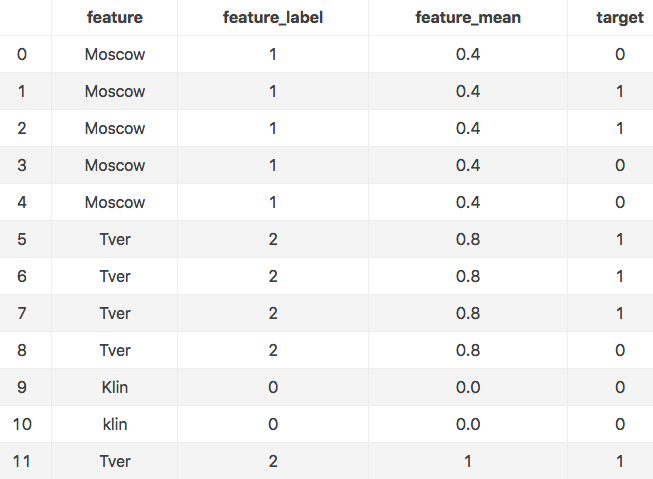

我们想对feature变量进行编码，最直接、常用的方式就是label encoding，这就是第二列数据。

平均编码以不同的方式去完成这个任务，它用每个城市自身对应的目标均值来进行编码。例如，对于Moscow，我们有五行，三个0和两个1。 所以我们用2除以5或0.4对它进行编码。用同样的方法处理其他城市。

现在了解一下细节。当我们的数据集非常大，包含数百个不同的城市，让我们试着比较一下。我们绘制了0,1 class的直方图。
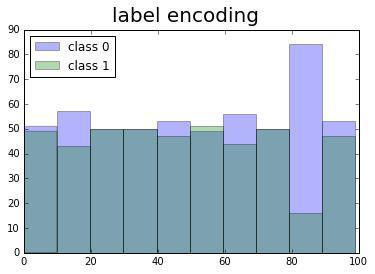

在label encoding的情况下，我们得到的图看起来没有任何逻辑顺序。
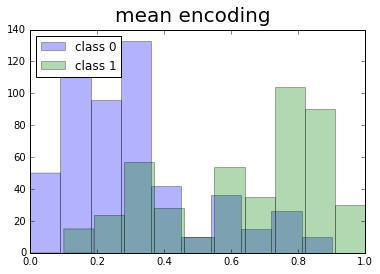

但是当我们使用mean encoding对目标进行编码时，类看起来更加可分了，像是被排序过。

一般来说，模型对复杂、非线性的特征目标越依赖，均值编码越有效。例如树模型的深度有限，可以用平均编码来补偿它，可以用它的短板来获得更好的分数。

以上只是一个例子，传递的是一种思想，实际上可以做很多类似的操作。

### Regularization

为了减少过拟合，需要对训练数据进行某种正规化。现在我们将实施四种不同的正则化方法。

    1.CV loop inside training data;
    2.Smoothing;
    3.Adding random noise;
    4.Sorting and calculating expanding mean.

## target encoding

In [1]:
from subprocess import check_output

In [4]:
print(check_output(['ls', '.']).decode("utf8"))

Automatic Feature Engineering - An Event-Driven Approach.ipynb
CatFeatureEncoder.ipynb
data
data_preprocessing.ipynb
data_splitter.ipynb
datasets.ipynb
feature_engineering.ipynb
imbalanced_dataset_ops.ipynb



### Target encoding with smoothing
https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features

min_samples_leaf define a threshold where prior and target mean (for a given category value) have the same weight. Below the threshold prior becomes more important and above mean becomes more important.

How weight behaves against value counts is controlled by smoothing parameter

In [14]:
import numpy as np
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

In [6]:
def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

#### Testing with ps_car_11_cat
这个示例通过对某一数据集的ps_car_11_cat列，共有104个分类进行target_encode编码和不处理(按照1,2....进行编码)进行对比，来展示target_encode的有效性。

进行target encode肯定会更加有效。因为原分类只是有业务含义，而并没有和target_label联系起来，即类别1中target_label的分布和类别1本身并没有关系；

相较而言，target encode考虑了target_label的prior(先验概率：所有样本的均值)和后验概率(在分类1中的均值)，假设类别1经过target encode编码后的值为0.9，类别2经过target encode编码后的值为0.1，则表示属于类别1的样本 比 属于类别2的样本 被分类为target_label=1的概率更大。

显然，通过target encode编码的数值比原来的1,2,3...等更有意义！

In [5]:
data_dir = '/Users/luoyonggui/Downloads/ps_car_11_cat'

In [6]:
import os
import pandas as pd

# reading data
trn_df = pd.read_csv(os.path.join(data_dir, "train.csv"), index_col=0)
sub_df = pd.read_csv(os.path.join(data_dir, "test.csv"), index_col=0)

In [24]:
trn_series=trn_df["ps_car_11_cat"].to_frame()
tst_series=sub_df["ps_car_11_cat"]
target=trn_df.target
min_samples_leaf=100
smoothing=10
noise_level=0.01

In [25]:
import category_encoders as ce
encoder = ce.TargetEncoder(min_samples_leaf=100, smoothing=10)

In [12]:
trn_df["ps_car_11_cat"]

id
7           12
9           19
13          60
16         104
17          82
19         104
20          99
22          30
26          68
28         104
34          20
35          36
36         101
43         104
46         103
48          41
50          59
58         104
61          43
64          64
65          82
66         103
72          29
74          95
77         104
78          24
79           5
80          99
84         104
85          28
          ... 
1487945     10
1487951     64
1487952     14
1487954     38
1487957     87
1487958    104
1487962     37
1487963     16
1487964     64
1487968     95
1487973     82
1487975    104
1487976     57
1487980     47
1487983     14
1487988    102
1487990    101
1487992     17
1487994     49
1487996     19
1488001     53
1488005     72
1488008     27
1488009     26
1488011     20
1488013     31
1488016     63
1488017     31
1488021    101
1488027     34
Name: ps_car_11_cat, Length: 595212, dtype: int64

In [29]:
encoder.transform(trn_series, target)

,ps_car_11_cat
id,
7,12
9,19
13,60
16,104
17,82
19,104
20,99
22,30
26,68


In [45]:
trn_df["ps_car_11_cat"].value_counts().index

Int64Index([104, 103,  64,  87,  32,  28,   5,  99,  65,  82,
            ...
             23,  54,   4,  97,  35,  58,  81,  56,  18,  63],
           dtype='int64', length=104)

In [34]:
target.value_counts()

0    573518
1     21694
Name: target, dtype: int64

In [27]:
temp = pd.concat([trn_series, target], axis=1)

In [37]:
# Compute target mean 
averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
averages[:2]

,mean,count
ps_car_11_cat,,
1,0.040528,3331
2,0.037995,2553


In [36]:
# Compute smoothing
smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
smoothing[:2]  # 类别数远大于min_samples_leaf为1，类别数等于min_samples_leaf为0.5，类别数远小于min_samples_leaf为0


ps_car_11_cat
1    1.0
2    1.0
Name: count, dtype: float64

In [39]:
# Apply average function to all target data
prior = target.mean()
prior

0.036447517859182946

In [38]:
# The bigger the count the less full_avg is taken into account
averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
averages.head(2)

,mean,count,target
ps_car_11_cat,,,
1,0.040528,3331,0.040528
2,0.037995,2553,0.037995


In [40]:
averages.drop(["mean", "count"], axis=1, inplace=True)

In [42]:
# Apply averages to trn and tst series
ft_trn_series = pd.merge(
    trn_series.to_frame(trn_series.name),
    averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
    on=trn_series.name,
    how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
ft_trn_series[:2]

0    0.038642
1    0.023936
Name: ps_car_11_cat_mean, dtype: float64

In [43]:
# pd.merge does not keep the index so restore it
ft_trn_series.index = trn_series.index 
ft_tst_series = pd.merge(
    tst_series.to_frame(tst_series.name),
    averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
    on=tst_series.name,
    how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
# pd.merge does not keep the index so restore it
ft_tst_series.index = tst_series.index

#### 可以看到，如果noise_level=0的情况下，进行target_encoding分类后的分类数和原分类数是相等的，即进行target_encoding分类后的分类和原分类是一一对应的！

In [48]:
ft_trn_series.value_counts().shape

(104,)

In [15]:
# Target encode ps_car_11_cat
trn, sub = target_encode(trn_series=trn_df["ps_car_11_cat"], 
                         tst_series=sub_df["ps_car_11_cat"], 
                         target=trn_df.target, 
                         min_samples_leaf=100,
                         smoothing=10,
                         noise_level=0.01)
trn.head(10)

id
7     0.039233
9     0.023918
13    0.031433
16    0.044881
17    0.026149
19    0.045745
20    0.023126
22    0.030710
26    0.034575
28    0.044867
Name: ps_car_11_cat_mean, dtype: float64

#### Scatter plot of category values vs target encoding

We see that the category values are not ordered


Text(0, 0.5, 'Noisy target encoding')

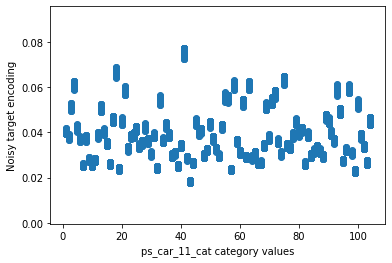

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(trn_df["ps_car_11_cat"], trn)
plt.xlabel("ps_car_11_cat category values")
plt.ylabel("Noisy target encoding")

Check AUC metric improvement after noisy encoding over 5 folds

In [17]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
f_cats = [f for f in trn_df.columns if "_cat" in f]
print("%20s   %20s | %20s" % ("", "Raw Categories", "Encoded Categories"))
for f in f_cats:
    print("%-20s : " % f, end="")
    e_scores = []
    f_scores = []
    for trn_idx, val_idx in folds.split(trn_df.values, trn_df.target.values):
        trn_f, trn_tgt = trn_df[f].iloc[trn_idx], trn_df.target.iloc[trn_idx]
        val_f, val_tgt = trn_df[f].iloc[trn_idx], trn_df.target.iloc[trn_idx]
        trn_tf, val_tf = target_encode(trn_series=trn_f, 
                                       tst_series=val_f, 
                                       target=trn_tgt, 
                                       min_samples_leaf=100, 
                                       smoothing=20,
                                       noise_level=0.01)
        f_scores.append(max(roc_auc_score(val_tgt, val_f), 1 - roc_auc_score(val_tgt, val_f)))
        e_scores.append(roc_auc_score(val_tgt, val_tf))
    print(" %.6f + %.6f | %6f + %.6f" 
          % (np.mean(f_scores), np.std(f_scores), np.mean(e_scores), np.std(e_scores)))

                             Raw Categories |   Encoded Categories
ps_ind_02_cat        :  0.506205 + 0.000689 | 0.509188 + 0.000854
ps_ind_04_cat        :  0.512617 + 0.000750 | 0.514773 + 0.001138
ps_ind_05_cat        :  0.520250 + 0.000331 | 0.531928 + 0.002118
ps_car_01_cat        :  0.528912 + 0.000830 | 0.551996 + 0.001401
ps_car_02_cat        :  0.531614 + 0.000863 | 0.532325 + 0.002039
ps_car_03_cat        :  0.539653 + 0.001308 | 0.539676 + 0.001713
ps_car_04_cat        :  0.536473 + 0.000557 | 0.536473 + 0.001657
ps_car_05_cat        :  0.530585 + 0.001437 | 0.530162 + 0.002016
ps_car_06_cat        :  0.515692 + 0.000867 | 0.542748 + 0.001264
ps_car_07_cat        :  0.522623 + 0.000284 | 0.522374 + 0.001254
ps_car_08_cat        :  0.520287 + 0.000608 | 0.521138 + 0.001483
ps_car_09_cat        :  0.504888 + 0.001253 | 0.523954 + 0.001027
ps_car_10_cat        :  0.500254 + 0.000200 | 0.499014 + 0.001608
ps_car_11_cat        :  0.512415 + 0.000432 | 0.574211 + 0.001496


## catboost是如何处理分类变量的？
https://catboost.ai/docs/concepts/algorithm-main-stages_cat-to-numberic.html

Before each split is selected in the tree, categorical features are transformed to numerical. This is done using various statistics on combinations of categorical features and combinations of categorical and numerical features.
### 步骤
The method of transforming categorical features to numerical generally includes the following stages:

    1. Permutating the set of input objects in a random order.

    2. Converting the label value from a floating point to an integer.
    The method depends on the machine learning problem being solved (which is determined by the selected loss function).
    
Problem| 	How transformation is performed
-|:--:
Regression| 	Quantization(连续值分段) is performed on the label value. The mode and number of buckets () are set in the starting parameters. All values located inside a single bucket are assigned a label value class – an integer in the range defined by the formula: <bucket ID – 1>.
Classification| 	Possible values for label value are “0” (doesn't belong to the specified target class) and “1” (belongs to the specified target class).
Multiclassification| 	The label values are integer identifiers of target classes (starting from “0”).
	
	3. Transforming categorical features to numerical features.
    基本的思路和target encoding差不多。。。
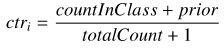
    
	

	



### 组合特征：聚合多个特征的示例
假设训练集中的对象属于两个分类特征:音乐类型(摇滚、独立)和音乐风格(舞蹈、古典)。这些特征可以以不同的组合形式出现。

CatBoost可以创建一个新特性，该特性是上述特性的组合(dance rock、classic rock、dance indie或indie classical)。可以组合任意数量的特性。

### Transforming categorical features to numerical features in classification(二分类)

1. CatBoost accepts a set of object properties and model values as input.

    The table below shows what the results of this stage look like.
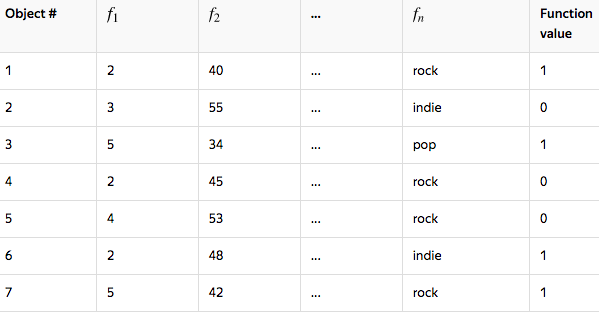

2. The rows in the input file are randomly shuffled several times. Multiple random permutations are generated.
    The table below shows what the results of this stage look like.
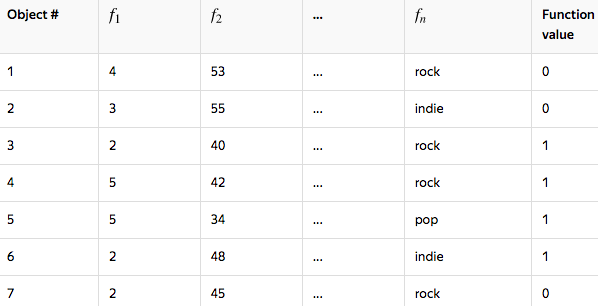

3. All categorical feature values are transformed to numerical using the following formula:
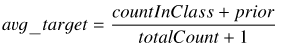

    * countInClass is how many times the label value was equal to “1” for objects with the current categorical feature value.
    * prior is the preliminary value for the numerator. It is determined by the starting parameters.
    * totalCount is the total number of objects (up to the current one) that have a categorical feature value matching the current one.


In the example with musical genres, accepts the values “rock”, “pop”, and “indie”, and prior is set to 0.05.

The table below shows what the results of this stage look like.
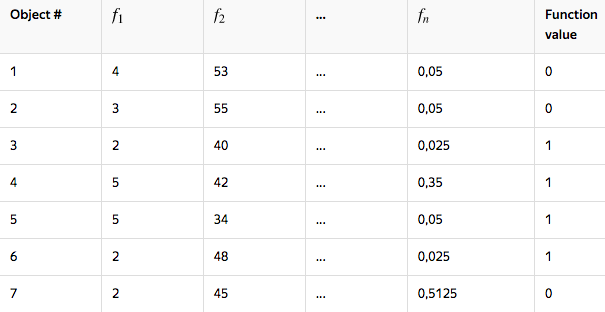

### One-hot encoding
One-hot encoding is also supported. Use one of the following training parameters to enable it.

可以通过指定one_hot_max_size，如果一个特征的分类数≤one_hot_max_size，则使用one-hot encoding!
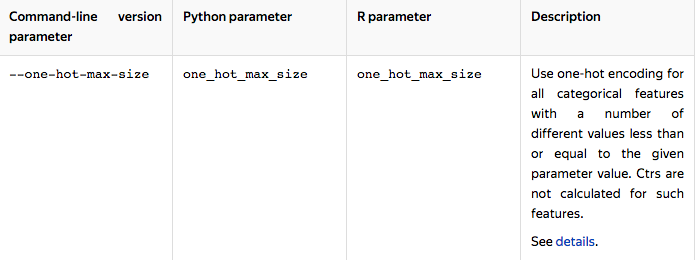

# 第三方包category_encoders
http://contrib.scikit-learn.org/categorical-encoding/index.html

优势：
* 几乎实现了所有主流的encoder
* 兼容sklearn pipeline

## 二进制编码器

二进制编码器是另一种可用于对分类变量进行编码的方法。如果一个列中有多个级别，那么这是一种很好的方法。虽然我们可以使用一个热编码来对使用1023列的具有1024个级别的列进行编码，但是使用二进制编码，我们可以通过使用10列来完成。

In [3]:
# !pip install category_encoders -U
!pip freeze | grep category

category-encoders==2.1.0


In [15]:
from category_encoders.binary import BinaryEncoder

In [17]:
be = BinaryEncoder(cols=['a'])

In [19]:
df = pd.DataFrame(pd.Series(range(16)), columns=['a'])

In [20]:
be.fit_transform(df)

,a_0,a_1,a_2,a_3,a_4
0,0,0,0,0,1
1,0,0,0,1,0
2,0,0,0,1,1
3,0,0,1,0,0
4,0,0,1,0,1
5,0,0,1,1,0
6,0,0,1,1,1
7,0,1,0,0,0
8,0,1,0,0,1
9,0,1,0,1,0


## 哈希散列编码器



可以将哈希散列编码器视为一个黑盒函数，它将字符串转换为0到某个预定值之间的数字。



它与二进制编码器不同，因为在二进制编码中，两个或多个俱乐部参数可能是1，而在哈希散列中只有一个值是1。



我们可以像这样使用哈希散列：

In [21]:
from category_encoders.hashing import HashingEncoder

In [22]:
he = HashingEncoder(cols=['a'])

In [23]:
he.fit_transform(df)

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7
0,0,0,1,0,0,0,0,0
1,0,0,0,1,0,0,0,0
2,0,0,0,0,1,0,0,0
3,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0
5,0,0,0,0,0,1,0,0
6,0,0,0,0,1,0,0,0
7,0,0,0,1,0,0,0,0
8,0,0,0,0,0,1,0,0
9,0,0,0,0,0,0,1,0


一定会有冲突（两个俱乐部有相同的编码。例如，尤文图斯足球俱乐部和巴黎圣日耳曼足球俱乐部具有相同的编码），但有时这种技术效果很好。